In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import sys 
from pyprojroot import here
sys.path.insert(0, str(here()))
from os.path import exists

import geopandas as gpd
from laos_gggi.data_functions import load_emdat_data, load_shapefile, load_rivers_data
from laos_gggi.data_functions.disaster_point_data import load_disaster_point_data, load_synthetic_non_disaster_points, load_grid_point_data

from laos_gggi.plotting import configure_plot_style
from laos_gggi.statistics import get_distance_to_rivers, prediction_to_gpd_df , set_plotting_data, add_data, add_country_effect
from laos_gggi.data_functions.combine_data import load_all_data
from pymc.model.transform.optimization import freeze_dims_and_data

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import xarray as xr
import arviz as az
import scipy
import nutpie
import pathlib

import pymc as pm
import pytensor.tensor as pt
from laos_gggi.sample import sample_or_load


from laos_gggi.transformers import CenterTransform, Standardize

configure_plot_style()

# Load and prepare data

In [3]:
world = load_shapefile('world')
# rivers = load_rivers_data()
laos = world.query('ISO_A3 == "LAO"')

# Select SEA shape
laos_neighboors = ["LAO", "VNM", "KHM", "THA"]
sea_map = world.query('ISO_A3 in @laos_neighboors')

In [4]:
sea_point_grid = load_grid_point_data(region='sea', grid_size=400)
laos_point_grid = load_grid_point_data(region='laos', grid_size=100)

Loading data found at C:\Users\camil\Documents\Servicios\OCDE-GGI\laos-climate-change\data\shapefiles\sea_points_400.shp\sea_points_400.shp.shp
Loading data found at C:\Users\camil\Documents\Servicios\OCDE-GGI\laos-climate-change\data\shapefiles\laos_points_100.shp\laos_points_100.shp.shp


In [5]:
all_data = load_all_data()
panel_data  = all_data["df_panel"][['population_density', 'gdp_per_cap', 'Population', 'precip']]
co2 = all_data["df_time_series"]["co2"]

In [6]:
disasters = load_disaster_point_data()
not_disasters = load_synthetic_non_disaster_points(by='country', multiplier=3)

merged_df = pd.concat([not_disasters.assign(is_disaster = 0), 
                       disasters.reset_index().assign(is_disaster=1)], 
                      ignore_index= True)

Loading data found at C:\Users\camil\Documents\Servicios\OCDE-GGI\laos-climate-change\data\synthetic_non_disasters_country_times_3.csv


In [7]:
from statsmodels.tsa.seasonal import STL

precipitation = all_data["gpcc"]
precip_deviation = precipitation.groupby('ISO').transform(lambda x: x - x.iloc[:30].mean()).rename(columns={'precip':'precip_deviation'})

df_clim = all_data["df_time_series"][["co2", "Temp", "precip"]].iloc[1:-1].dropna(subset=['Temp'])
trend =  STL(pd.DataFrame(df_clim["Temp"].dropna()), period=3).fit().trend
dev_from_trend_ocean_temp = (df_clim['Temp'] - trend).to_frame(name='dev_ocean_temp')

In [8]:
from functools import reduce
df = reduce(lambda l, r: pd.merge(l, r, left_on=['ISO', 'Start_Year'], right_index=True, how='left'), [merged_df, panel_data, precip_deviation])
df = reduce(lambda l, r: pd.merge(l, r , left_on=['Start_Year'], right_index=True, how='left'), [df, co2, dev_from_trend_ocean_temp])

In [9]:
#Creating log variables
log_list = ["distance_to_river", "distance_to_coastline", "Total_Affected", "Total_Damage_Adjusted", "population_density",
            "gdp_per_cap"]
for y in log_list:
    df[f"log_{y}"] = np.log(df[y])

#Creating the squared log variables
df["log_population_density_squared"] = 2 * df["log_population_density"]
df["log_gdp_per_cap_squared"] = 2 * df["log_gdp_per_cap"]

C:\Users\camil\miniforge3\envs\laos-climate-change\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [10]:
#Delimiting data set
columns_to_use = ['ISO', 'Start_Year', "is_disaster", 'distance_to_river', 'distance_to_coastline', 'is_island',
               "Population", "co2", "precip_deviation", "dev_ocean_temp", 'population_density',
               'gdp_per_cap', "lat", "long" , "geometry"]

features = ['log_distance_to_river', 'log_distance_to_coastline',
             "Population", "co2", "precip_deviation", "dev_ocean_temp", 'log_population_density', 'log_population_density_squared',
             'log_gdp_per_cap', 'log_gdp_per_cap_squared', ]

model_df = df[ list( set( columns_to_use).union(set(features)) )].dropna()

laos_2020_data =  model_df.loc[lambda x:( x.ISO == "LAO") & (x.Start_Year == "2020")].iloc[0 ]
for feature in features:
    if feature not in laos_point_grid.columns:
        laos_point_grid[feature] = laos_2020_data[feature].item()

In [11]:
# Define list of features standardized
features_stand = []
for feature in features:
    features_stand.append(feature + "__standardized" )

time_varying_features = ['Population','co2','precip_deviation','dev_ocean_temp','log_population_density',
                            'log_population_density_squared','log_gdp_per_cap','log_gdp_per_cap_squared']
time_varying_features_stand = []

for feature in time_varying_features:
    time_varying_features_stand.append(feature + "__standardized")

### Create SEA and Laos data sets

In [12]:
#Create the geodata set for sea disasters
sea_disasters = model_df.query('ISO in @laos_neighboors & is_disaster == 1')

sea_disasters_geo = gpd.GeoDataFrame(
                sea_disasters,
    geometry=gpd.points_from_xy(sea_disasters["long"], sea_disasters["lat"]), crs="EPSG:4326"
            )


# Create the geodata set for Laos disasters
laos_disasters = model_df.query('ISO == "LAO" & is_disaster == 1')

laos_disasters_geo = gpd.GeoDataFrame(
                laos_disasters,
    geometry=gpd.points_from_xy(laos_disasters["long"], laos_disasters["lat"]), crs="EPSG:4326"
            )

In [13]:
# Merge points with world ISO
sea_point_grid_extended = gpd.sjoin(sea_point_grid, sea_map, how="left", )

In [14]:
#We define the map and the df for south east asia
sea_df = model_df.query('ISO in @laos_neighboors')

#Tranform to geopandas df
sea_df = gpd.GeoDataFrame(sea_df,  geometry=gpd.points_from_xy(sea_df["long"],
                                sea_df["lat"]),crs="EPSG:4326")


#We define the map and the df for Laos
laos_map = world.query('ISO_A3 == "LAO"')
lao_df = model_df.query('ISO == "LAO"')

#Tranform to geopandas df
lao_df = gpd.GeoDataFrame(lao_df,  geometry=gpd.points_from_xy(lao_df["long"],
                                lao_df["lat"]),crs="EPSG:4326")

In [15]:
# Standardize data
transformer_stand_ =  Standardize().fit(sea_df)
sea_df_stand = transformer_stand_.transform(sea_df)

country_2020_data = {}
country_2020_data_df = pd.DataFrame()
for country in laos_neighboors:
    country_2020_data[country] = sea_df_stand.query('Start_Year == "2020-01-01 00:00:00" & ISO == @country').iloc[[0]][features_stand + ["ISO"]]
    country_2020_data_df = pd.concat([country_2020_data_df, country_2020_data[country]])

sea_point_grid_extended = pd.merge(sea_point_grid_extended, country_2020_data_df, how = "left", left_on= "ISO_A3", right_on="ISO" ) 



# Standardize data
transformer_stand_lao =  Standardize().fit(lao_df)
lao_df_stand = transformer_stand_lao.transform(lao_df)

C:\Users\camil\AppData\Local\Temp\ipykernel_44160\3599897507.py:8: FutureWarning: The behavior of 'isin' with dtype=datetime64[ns] and castable values (e.g. strings) is deprecated. In a future version, these will not be considered matching by isin. Explicitly cast to the appropriate dtype before calling isin instead.
  country_2020_data[country] = sea_df_stand.query('Start_Year == "2020-01-01 00:00:00" & ISO == @country').iloc[[0]][features_stand + ["ISO"]]
C:\Users\camil\AppData\Local\Temp\ipykernel_44160\3599897507.py:8: FutureWarning: The behavior of 'isin' with dtype=datetime64[ns] and castable values (e.g. strings) is deprecated. In a future version, these will not be considered matching by isin. Explicitly cast to the appropriate dtype before calling isin instead.
  country_2020_data[country] = sea_df_stand.query('Start_Year == "2020-01-01 00:00:00" & ISO == @country').iloc[[0]][features_stand + ["ISO"]]
C:\Users\camil\AppData\Local\Temp\ipykernel_44160\3599897507.py:8: FutureWar

We create the merged sea_point_grid_extended for predictions

In [16]:
# Merge points with world ISO
sea_point_grid_extended = gpd.sjoin(sea_point_grid, sea_map, how="left", )

In [17]:
country_2020_data = {}
country_2020_data_df = pd.DataFrame()
for country in laos_neighboors:
    country_2020_data[country] = sea_df_stand.query('Start_Year == "2020-01-01 00:00:00" & ISO == @country').iloc[[0]][features_stand + ["ISO"]]
    country_2020_data_df = pd.concat([country_2020_data_df, country_2020_data[country]])

sea_point_grid_extended = pd.merge(sea_point_grid_extended, country_2020_data_df, how = "left", left_on= "ISO_A3", right_on="ISO" ) 

C:\Users\camil\AppData\Local\Temp\ipykernel_44160\4161900301.py:4: FutureWarning: The behavior of 'isin' with dtype=datetime64[ns] and castable values (e.g. strings) is deprecated. In a future version, these will not be considered matching by isin. Explicitly cast to the appropriate dtype before calling isin instead.
  country_2020_data[country] = sea_df_stand.query('Start_Year == "2020-01-01 00:00:00" & ISO == @country').iloc[[0]][features_stand + ["ISO"]]
C:\Users\camil\AppData\Local\Temp\ipykernel_44160\4161900301.py:4: FutureWarning: The behavior of 'isin' with dtype=datetime64[ns] and castable values (e.g. strings) is deprecated. In a future version, these will not be considered matching by isin. Explicitly cast to the appropriate dtype before calling isin instead.
  country_2020_data[country] = sea_df_stand.query('Start_Year == "2020-01-01 00:00:00" & ISO == @country').iloc[[0]][features_stand + ["ISO"]]
C:\Users\camil\AppData\Local\Temp\ipykernel_44160\4161900301.py:4: FutureWar

In [18]:
# Creating the laos_point_grid_extended
laos_point_grid["ISO"] = "LAO"
laos_point_grid_extended = pd.merge(laos_point_grid, country_2020_data_df, how = "left", left_on= "ISO", right_on="ISO" ) 

# Estimation for Laos only: HSGP

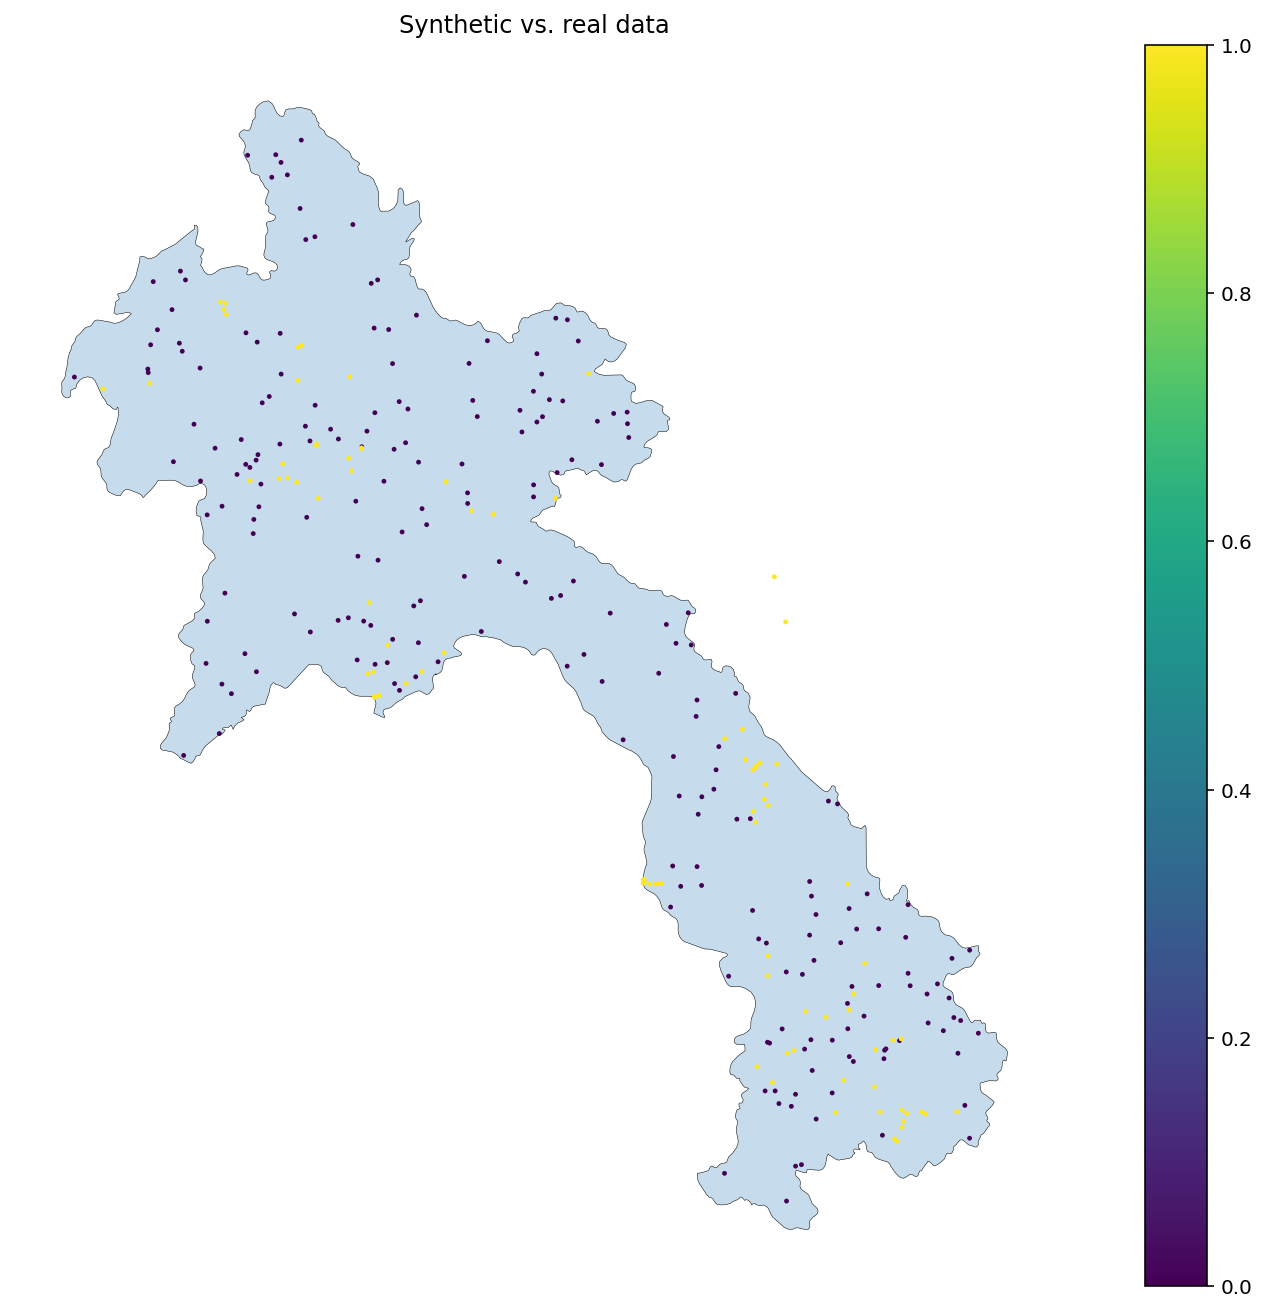

In [19]:
fig, ax = plt.subplots(figsize=(14, 9), dpi=144)
laos_map.plot(facecolor='tab:blue', alpha=0.25, ax=ax)
laos_map.plot(facecolor='none', edgecolor='k', lw=0.25, ax=ax)

lao_df.plot('is_disaster', 
                                      markersize=2, 
                                      ax=ax, 
                                      legend=True, 
                                      # categorical=True,
                                      cmap='viridis')
ax.axis('off')
plt.title("Synthetic vs. real data")
plt.show()

In [20]:
#Define cooords
is_disaster_idx , is_disaster = pd.factorize(lao_df["is_disaster"])
ISO_idx, ISO = pd.factorize(lao_df["ISO"]) 
obs_idx = lao_df.index
gp_features = ["lat", "long"]

#Creating idx
xr_idx = xr.Coordinates.from_pandas_multiindex(lao_df.set_index(['ISO', 'Start_Year']).index, 'obs_idx')


#Set coords
coords_lao = {"is_disaster" : is_disaster,
        "obs_idx": obs_idx,
        "ISO": ISO,
        "feature": features_stand,
        "gp_feature":gp_features }


In [22]:
with pm.Model(coords=coords_lao) as model_lao_1_hsgp:
    #Declare data
    X, Y= add_data(features= features_stand ,  target = "is_disaster", df =  lao_df_stand, )
    is_island = pm.Data("is_island",  lao_df_stand["is_island"].astype(bool), dims = ["obs_idx"] )
    
    # #Country effect
    # country_effect = pm.Normal("country_effect", mu = 0, sigma =1, dims = ["ISO"])

    #Betas
    # beta_sigma = [0.1] * 10
    # beta = pm.Normal("beta", mu = 0, sigma = beta_sigma, dims = ["feature"])
    # is_island_beta = pm.Normal("'is_island'", mu = 1, sigma = 1)

    # HSGP process
    X_gp = pm.Data("X_gp", lao_df_stand[["lat", "long"]])

    # Prior on the HSGP
    eta = pm.Exponential("eta", scale=2.0)
    ell_params = pm.find_constrained_prior(
        pm.Lognormal, lower=0.5, upper=10.0, mass=0.95, init_guess={"mu": 1.0, "sigma": 1.0}
    )
    ell = pm.Lognormal("ell", **ell_params, dims=["gp_feature"])
    cov_func = eta**2 * pm.gp.cov.Matern52(input_dim=2, ls=ell)

    m0, m1, c = 15, 15, 1.5
    gp = pm.gp.HSGP(m=[m0, m1], c=c, cov_func=cov_func)

    phi, sqrt_psd = gp.prior_linearized(X=X_gp)

    basis_coeffs = pm.Normal("basis_coeffs", size=gp.n_basis_vectors)
    HSGP_component = pm.Deterministic("HSGP_component", phi @ (basis_coeffs * sqrt_psd))

    #Model mu
    # p = (
    #     #country_effect[ISO_idx] + 
    #     (X * beta).sum(axis=1) + (is_island * is_island_beta) + HSGP_component)
    p = HSGP_component
    

    y_hat = pm.Bernoulli('y_hat', logit_p = p, observed=Y, dims='obs_idx')

C:\Users\camil\AppData\Local\Temp\ipykernel_44160\1562536690.py:19: FutureWarning: find_constrained_prior is deprecated and will be removed in a future version. Please use maxent function from PreliZ. https://preliz.readthedocs.io/en/latest/api_reference.html#preliz.unidimensional.maxent
  ell_params = pm.find_constrained_prior(


In [24]:
sample_kwargs =  {"nuts_sampler": "nutpie", "nuts_sampler_kwrags": {"backend": "jax", "gradient_backend": "jax"  } }
model_lao_1_hsgp_idata = sample_or_load( fp = "../model_lao_1_hsgp.idata", model =  model_lao_1_hsgp, sample_kwargs = sample_kwargs)

In [ ]:
#Full model predictions
laos_grid_2d_basis = transformer__center.transform(laos_points[["lat", "lon"]].rename(columns = {"lon": "long"}))
laos_grid_2d = np.array(laos_grid_2d_basis)


with pm.Model(coords=coords_lao) as model_lao_1_hsgp_plot:
    #Declare data
    # laos_is_island = laos_points["is_island"]
    # laos_distances = laos_points[["log_distance_to_coastline", "log_distance_to_river"]]
    # time_varying_features_2020 =(lao_df_stand.loc[18901,][time_varying_features_stand]).astype(float)

    # #Flat variables
    # is_island_beta = pm.Flat("is_island_beta")
    # beta = pm.Flat("beta", dims = ["feature"])
    # country_effect = pm.Flat("country_effect", dims = ["ISO"])
    
    eta = pm.Flat("eta")
    ell = pm.Flat("ell", dims=["gp_feature"])
    cov_func = eta**2 * pm.gp.cov.Matern52(input_dim=2, ls=ell)
    gp = pm.gp.HSGP(m=[m0, m1], c=c, cov_func=cov_func)
    basis_coeffs = pm.Flat("basis_coeffs", size=gp.n_basis_vectors)

    phi, sqrt_psd = gp.prior_linearized(X=laos_grid_2d)
    
    f_plot = pm.Deterministic("f_plot", phi @ (basis_coeffs * sqrt_psd))
    
    
    # point_prediction = pm.Deterministic("point_prediction", 
    #                          country_effect[0] 
    #                          + ( is_island_beta * laos_is_island) 
    #                         + (beta[0] * laos_distances["log_distance_to_river"] ) + (beta[1] * laos_distances["log_distance_to_coastline"])
    #                         + f_plot
    #                         +  (beta[2:] @ time_varying_features_2020 )
    #                           )
    point_prediction =  pm.Deterministic("point_prediction", f_plot)
    
    point_probability = pm.Deterministic('point_probability', pm.math.invlogit(point_prediction))

    model_lao_1_hsgp_plot_idata = pm.sample_posterior_predictive(
        model_lao_1_hsgp_idata, var_names= ["point_prediction", "point_probability"]
    )
    

In [ ]:
#Store df of predictions
model_lao_1_hsgp_idata_predictions = {}
model_lao_1_hsgp_idata_predictions_geo = {}

for x in ["point_prediction", "point_probability"]:

    
    model_lao_1_hsgp_idata_predictions[x] = (model_lao_1_hsgp_plot_idata.posterior_predictive.mean(dim=("chain", "draw"))
                                   [x]
                                   .to_dataframe())
    
    #Merge predictions with Laos points
    model_lao_1_hsgp_idata_predictions[x] = pd.merge(model_lao_1_hsgp_idata_predictions[x], laos_points, 
                                           left_index=True, right_index=True,
                                           how = "left")
    
    #Transform into geo Data Frame
    model_lao_1_hsgp_idata_predictions_geo[x] = gpd.GeoDataFrame(
                    model_lao_1_hsgp_idata_predictions[x],
        geometry=gpd.points_from_xy(model_lao_1_hsgp_idata_predictions[x]["lon"],
                                    model_lao_1_hsgp_idata_predictions[x]["lat"]),crs="EPSG:4326"
                )

In [ ]:
#Plot the predictions
fig, ax = plt.subplots()
model_lao_1_hsgp_idata_predictions_geo["point_prediction"].plot("point_prediction",legend=True, ax=ax,markersize =5)
laos_disasters_geo.plot(ax=ax, alpha = 0.3, c = "r",markersize =5, )
plt.title("point_prediction Laos", );

In [ ]:
#Plot the predictions
fig, ax = plt.subplots()
model_lao_1_hsgp_idata_predictions_geo["point_probability"].plot("point_probability",legend=True, ax=ax,markersize =5)
laos_disasters_geo.plot(ax=ax, alpha = 0.3, c = "r",markersize =5, )
plt.title("point_probability Laos", );

# Estimation for Laos only: Full model

In [ ]:
fig, ax = plt.subplots(figsize=(14, 9), dpi=144)
laos_map.plot(facecolor='tab:blue', alpha=0.25, ax=ax)
laos_map.plot(facecolor='none', edgecolor='k', lw=0.25, ax=ax)

lao_df.plot('is_disaster', 
                                      markersize=2, 
                                      ax=ax, 
                                      legend=True, 
                                      # categorical=True,
                                      cmap='viridis')
ax.axis('off')
plt.title("Synthetic vs. real data")
plt.show()

In [ ]:
#Define cooords
is_disaster_idx , is_disaster = pd.factorize(lao_df["is_disaster"])
ISO_idx, ISO = pd.factorize(lao_df["ISO"]) 
obs_idx = lao_df.index
gp_features = ["lat", "long"]

#Creating idx
xr_idx = xr.Coordinates.from_pandas_multiindex(lao_df.set_index(['ISO', 'Start_Year']).index, 'obs_idx')


# Standardize data
transformer_stand_ =  Standardize().fit(lao_df)
lao_df_stand = transformer_stand_.transform(lao_df)

# Center the lat and long variables for the HSGP
transformer__center = CenterTransform().fit(lao_df[["lat", "long"]])
centered_HSGP_data = transformer__center.transform(lao_df[["lat", "long"]])

#Set coords
coords_lao = {"is_disaster" : is_disaster,
        "obs_idx": obs_idx,
        "ISO": ISO,
        "feature": features_stand,
        "gp_feature":gp_features }

In [ ]:
with pm.Model(coords=coords_lao) as model_lao_1_hsgp:
    #Declare data
    X, Y= add_data(features= features_stand ,  target = "is_disaster", df =  lao_df_stand, )
    is_island = pm.Data("is_island",  lao_df["is_island"].astype(bool), dims = ["obs_idx"] )
    
    # #Country effect
    # country_effect = pm.Normal("country_effect", mu = 0, sigma =1, dims = ["ISO"])

    #Betas
    beta_sigma = [0.1] * 10
    beta = pm.Normal("beta", mu = 0, sigma = beta_sigma, dims = ["feature"])
    is_island_beta = pm.Normal("'is_island'", mu = 1, sigma = 1)

    # HSGP process
    X_gp = pm.Data("X_gp", centered_HSGP_data)

    # Prior on the HSGP
    eta = pm.Exponential("eta", scale=2.0)
    ell_params = pm.find_constrained_prior(
        pm.Lognormal, lower=0.5, upper=10.0, mass=0.95, init_guess={"mu": 1.0, "sigma": 1.0}
    )
    ell = pm.Lognormal("ell", **ell_params, dims=["gp_feature"])
    cov_func = eta**2 * pm.gp.cov.Matern52(input_dim=2, ls=ell)

    m0, m1, c = 15, 15, 1.5
    gp = pm.gp.HSGP(m=[m0, m1], c=c, cov_func=cov_func)

    phi, sqrt_psd = gp.prior_linearized(X=X_gp)

    basis_coeffs = pm.Normal("basis_coeffs", size=gp.n_basis_vectors)
    HSGP_component = pm.Deterministic("HSGP_component", phi @ (basis_coeffs * sqrt_psd))

    #Model mu
    p = (
        #country_effect[ISO_idx] + 
        (X * beta).sum(axis=1) + (is_island * is_island_beta) + HSGP_component)
    # p = HSGP_component
    

    y_hat = pm.Bernoulli('y_hat', logit_p = p, observed=Y, dims='obs_idx')

In [ ]:
if exists("model_lao_full.idata"):
    model_lao_1_full_idata = az.from_netcdf("model_lao_full.idata")


else:
    compiled_model = nutpie.compile_pymc_model(freeze_dims_and_data(model_lao_1_hsgp), backend="jax", gradient_backend='jax')
    model_lao_1_full_idata = nutpie.sample(compiled_model)
    #Rename the is_island variable 
    model_lao_1_full_idata = model_lao_1_full_idata.rename({"'is_island'": "is_island_beta"})
    #Save the idata
    az.to_netcdf(data = model_lao_1_full_idata, filename= pathlib.Path("model_lao_full.idata"))

In [ ]:
#Full model predictions
laos_grid_2d_basis = transformer__center.transform(laos_points[["lat", "lon"]].rename(columns = {"lon": "long"}))
laos_grid_2d = np.array(laos_grid_2d_basis)


with pm.Model(coords=coords_lao) as model_lao_1_hsgp_plot:
    #Declare data
    laos_is_island = laos_points["is_island"]
    laos_distances = transformer_stand_.transform(laos_points)[["log_distance_to_river__standardized", "log_distance_to_coastline__standardized"]]
    time_varying_features_2020 =(lao_df_stand[time_varying_features_stand].loc[18901,]).astype(float)

    #Flat variables
    is_island_beta = pm.Flat("is_island_beta")
    beta = pm.Flat("beta", dims = ["feature"])
    # country_effect = pm.Flat("country_effect", dims = ["ISO"])
    
    eta = pm.Flat("eta")
    ell = pm.Flat("ell", dims=["gp_feature"])
    cov_func = eta**2 * pm.gp.cov.Matern52(input_dim=2, ls=ell)
    gp = pm.gp.HSGP(m=[m0, m1], c=c, cov_func=cov_func)
    basis_coeffs = pm.Flat("basis_coeffs", size=gp.n_basis_vectors)

    phi, sqrt_psd = gp.prior_linearized(X=laos_grid_2d)
    
    f_plot = pm.Deterministic("f_plot", phi @ (basis_coeffs * sqrt_psd))
    
    
    point_prediction = pm.Deterministic("point_prediction", 
                             # country_effect[0] 
                             ( is_island_beta * laos_is_island) 
                            + (beta[0] * laos_distances["log_distance_to_river__standardized"] ) + (beta[1] * laos_distances["log_distance_to_coastline__standardized"])
                            + f_plot
                            +  (beta[2:] @ time_varying_features_2020 )
                              )
    
    point_probability = pm.Deterministic('point_probability', pm.math.invlogit(point_prediction))

    model_lao_1_full_plot_idata = pm.sample_posterior_predictive(
        model_lao_1_full_idata, var_names= ["point_prediction", "point_probability"]
    )
    

In [ ]:
#Store df of predictions
model_lao_1_full_predictions = {}
model_lao_1_full_predictions_geo = {}

for x in ["point_prediction", "point_probability"]:
    
    model_lao_1_full_predictions[x] = (model_lao_1_full_plot_idata.posterior_predictive.mean(dim=("chain", "draw"))
                                   [x]
                                   .to_dataframe())
    
    #Merge predictions with Laos points
    model_lao_1_full_predictions[x] = pd.merge(model_lao_1_full_predictions[x], laos_points, 
                                           left_index=True, right_index=True,
                                           how = "left")
    
    #Transform into geo Data Frame
    model_lao_1_full_predictions_geo[x] = gpd.GeoDataFrame(
                    model_lao_1_full_predictions[x],
        geometry=gpd.points_from_xy(model_lao_1_full_predictions[x]["lon"],
                                    model_lao_1_full_predictions[x]["lat"]),crs="EPSG:4326"
                )

In [ ]:
#Plot the predictions
fig, ax = plt.subplots()
model_lao_1_full_predictions_geo["point_prediction"].plot("point_prediction",legend=True, ax=ax,markersize =5)
laos_disasters_geo.plot(ax=ax, alpha = 0.3, c = "r",markersize =5, )
plt.title("point_prediction Laos", );

In [ ]:
#Plot the predictions
fig, ax = plt.subplots()
model_lao_1_full_predictions_geo["point_probability"].plot("point_probability",legend=True, ax=ax,markersize =5)
laos_disasters_geo.plot(ax=ax, alpha = 0.3, c = "r",markersize =5, )
plt.title("point_probability Laos", );